In [1]:
import torch
from utils.dataloader import get_dataloaders
from utils.train import train_model, test_model
from utils.metrics import (
    plot_history,
    plot_confusion_matrix,
    save_results_csv,
    plot_model_comparison,
    plot_roc_auc,
    compute_full_metrics,
    save_epoch_history_excel
)

from models.single_models import get_single_model
from models.hybrid_models import get_hybrid_model, get_multi_hybrid_model

C:\Users\navne\anaconda3\envs\lung_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:",device)

Using device: cuda


In [3]:
DATA_DIR = "lung_ct_split"

preprocess_cfg = {
    "windowing": False,
    "clahe": True,
    "hist_eq": False,
    "gaussian": True,
    "median": False,
    "sharpen_flag": False,
    "norm_type": "minmax"
}

train_loader, val_loader, test_loader, class_names = get_dataloaders(
    data_dir = DATA_DIR,
    batch_size = 16,
    preprocess_config= preprocess_cfg,
)
print(train_loader)
print("Classes: ",class_names)

Classes:  ['Bengin cases', 'Malignant cases', 'Normal cases']


In [4]:
len(train_loader)

48

In [5]:
from PIL import Image
import os

bad_files = []

for root, _, files in os.walk(DATA_DIR):
    for f in files:
        path = os.path.join(root, f)
        try:
            Image.open(path).verify()
        except:
            bad_files.append(path)

print("Corrupted images:", len(bad_files))
bad_files[:10]

Corrupted images: 0


[]

In [8]:
EPOCHS = 1

single_model_names = [
    "resnet50",
    # "vgg16",
    # "efficientnet",
    # "inception",
    # "vit",
]

results = {}
histories = {}


===== Training RESNET50 =====
Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): Batc

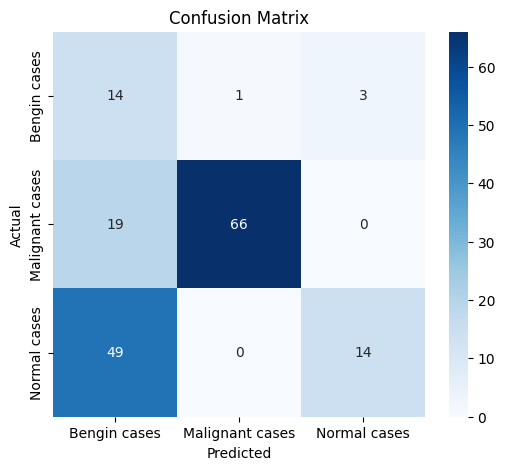

✅ ROC-AUC saved → results/roc_auc/resnet50.png


In [9]:
for name in single_model_names:
    print(f"\n===== Training {name.upper()} =====")

    model = get_single_model(name, num_classes=len(class_names)).to(device)

    model, history = train_model(
        model,
        train_loader,
        val_loader,
        device,
        epochs=EPOCHS,
        model_name=name.upper()
    )

    model_name = f"{name}_ep{EPOCHS}"

    save_epoch_history_excel(
        history,
        model_name=model_name
    )

    test_acc, report, cm, labels, preds, probs, images = test_model(
        model,
        test_loader,
        device,
        class_names,
        return_details=True
    )

    accuracy, precision, recall, f1 = compute_full_metrics(labels, preds)
    results[name] = test_acc
    histories[name] = history

    print(f"\n{name} Test Accuracy: {test_acc:.4f}")
    print(report)

    plot_confusion_matrix(cm, class_names)
    
    plot_roc_auc(
        labels,
        probs,
        class_names,
        save_path=f"results/roc_auc/{name}.png"
    )


===== Training MULTI_CNN =====

Epoch 1/20
Train Loss: 0.6322 | Train Acc: 0.7679
Val   Loss: 0.4305 | Val   Acc: 0.8659

Epoch 2/20
Train Loss: 0.3838 | Train Acc: 0.8709
Val   Loss: 0.3042 | Val   Acc: 0.9024

Epoch 3/20
Train Loss: 0.3454 | Train Acc: 0.8840
Val   Loss: 0.5181 | Val   Acc: 0.8720

Epoch 4/20
Train Loss: 0.2996 | Train Acc: 0.9074
Val   Loss: 0.1701 | Val   Acc: 0.9329

Epoch 5/20
Train Loss: 0.2263 | Train Acc: 0.9257
Val   Loss: 2.0464 | Val   Acc: 0.5366

Epoch 6/20
Train Loss: 0.1659 | Train Acc: 0.9596
Val   Loss: 0.1563 | Val   Acc: 0.9329

Epoch 7/20
Train Loss: 0.1783 | Train Acc: 0.9531
Val   Loss: 0.1349 | Val   Acc: 0.9573

Epoch 8/20
Train Loss: 0.1521 | Train Acc: 0.9544
Val   Loss: 0.4145 | Val   Acc: 0.8415

Epoch 9/20
Train Loss: 0.1252 | Train Acc: 0.9635
Val   Loss: 0.3905 | Val   Acc: 0.8598

Epoch 10/20
Train Loss: 0.1079 | Train Acc: 0.9713
Val   Loss: 0.1951 | Val   Acc: 0.9329

Epoch 11/20
Train Loss: 0.1704 | Train Acc: 0.9596
Val   Loss: 2.6

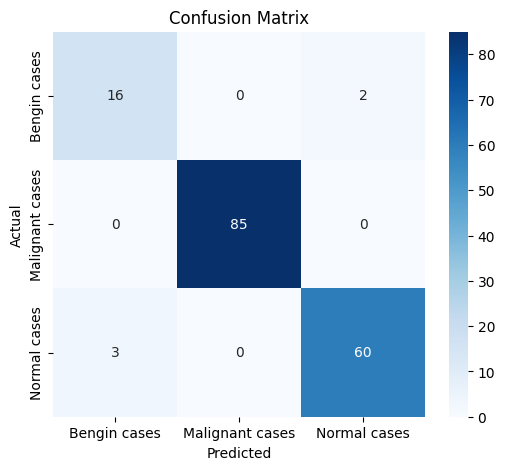

✅ ROC-AUC saved → results/roc_auc/multi_cnn.png


In [7]:
hybrid_configs = {
    # "resnet50_vit": lambda: get_hybrid_model("resnet50"),
    # "efficientnet_vit": lambda: get_hybrid_model("efficientnet_b0"),
    "multi_cnn": lambda: get_multi_hybrid_model(
        cnn_list=("resnet50", "vgg16", "inception_v3")
    ),
}

EPOCHS = 20

for name, builder in hybrid_configs.items():
    print(f"\n===== Training {name.upper()} =====")

    model = builder().to(device)

    model, history = train_model(
        model,
        train_loader,
        val_loader,
        device,
        epochs=EPOCHS,
    )

    test_acc, report, cm, labels, preds, probs, images = test_model(
        model,
        test_loader,
        device,
        class_names,
        return_details=True
    )

    accuracy, precision, recall, f1 = compute_full_metrics(labels, preds)
    results[name] = test_acc
    histories[name] = history

    print(f"\n{name} Test Accuracy: {test_acc:.4f}")
    print(report)

    plot_confusion_matrix(cm, class_names)
    
    plot_roc_auc(
        labels,
        probs,
        class_names,
        save_path=f"results/roc_auc/{name}.png"
    )

✅ Detailed experiment results saved → ./results/reports/results.csv


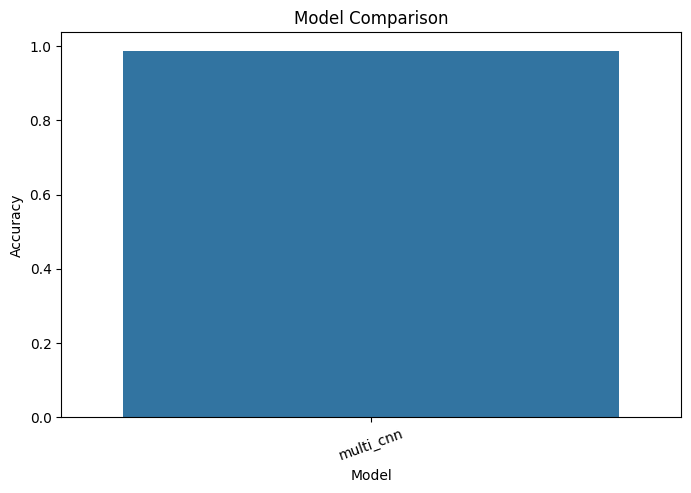

In [8]:
save_results_csv(results, "./results/reports/results.csv",preprocess_cfg,EPOCHS,precision=precision,recall=recall,f1=f1)
plot_model_comparison(results, "./results/plots/comparison.png")

Best model: resnet50_vit


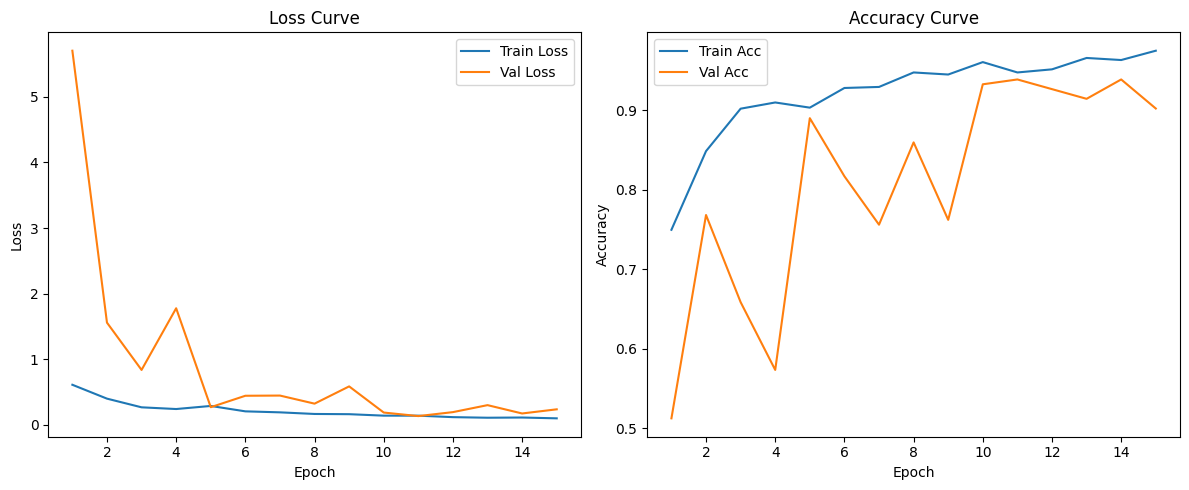

In [27]:
best_model_name = max(results, key=results.get)
print("Best model:", best_model_name)

plot_history(
    histories[best_model_name],
    f"./results/plots/{best_model_name}_history.png",
)

In [9]:
DATA_DIR = "lung_ct_split"

preprocess_cfg = {
    "windowing": False,
    "clahe": True,
    "hist_eq": False,
    "gaussian": True,
    "median": False,
    "sharpen_flag": False,
    "norm_type": "minmax"
}

train_loadr, val_loadr, test_loadr, class_nam = get_dataloaders(
    data_dir = DATA_DIR,
    batch_size = 16,
    preprocess_config= preprocess_cfg,
)
print(len(train_loadr))
print("Classes: ",class_nam)

48
Classes:  ['Bengin cases', 'Malignant cases', 'Normal cases']
